In [166]:
import pyfmi
import numpy as np
from matplotlib import pyplot as plt

In [167]:
##PATH TO FMU FILE: 
pth = "../fmus/"
fnm = "hx_delta.fmu"
file_path = pth+fnm
print(file_path)

../fmus/hx_delta.fmu


In [168]:
##Create Multiple Instances of the same model:
n_instances = 1
fmus=[]
for ifmu in range(n_instances):
    fmus.append(pyfmi.load_fmu(file_path))

In [169]:
def print_variables(fmus):
    '''display the variable names and corresponding default values associated with the model:'''
    variable_names = fmus[0].get_model_variables().keys()
    for variable_name in variable_names:
        value = fmus[0].get(variable_name)
        print(variable_name + ': '+ str(value))

print_variables(fmus)

T1_in: [0.]
m1_in: [0.]
T2_in: [0.]
m2_in: [0.]
T2_out: [0.]
m2_out: [0.]
T1_out: [0.]
m1_out: [0.]
K: [2584000.]
T1_ini: [68.]
T2_ini: [91.]
cp1: [4190.]
cp2: [4190.]
m1: [400.]
m2: [400.]
time: [0.]


In [170]:
## Define Connections between the instances:
#Here we aim to simulate a counter-flow Heat Exchanger.
#Each instance (fmus[i]) corresponds to a portion of the heat exchanger containing two sides.
#We assume that the fluid at side 1 enters the system from the first instance (fmus[0])
#and flows in the order fmus[0]=>fmus[1]=>...=>fmus[n_instances-1]
#the fluid flowing at side 2 enters the system from the last instance (fmus[-1])
#and flows in the order fmus[n_instances-1]=>fmus[-2]=>...=>fmus[0]
connections = []
for ifmu in range(n_instances-1):
    connections.append((fmus[ifmu],'T1_out',fmus[ifmu+1],'T1_in'))
    connections.append((fmus[ifmu],'m1_out',fmus[ifmu+1],'m1_in'))
    connections.append((fmus[ifmu+1],'T2_out',fmus[ifmu],'T2_in'))
    connections.append((fmus[ifmu+1],'m2_out',fmus[ifmu],'m2_in'))

In [171]:
## SET THE INITIAL CONDITIONS FOR THE OUTPUT TEMPERATURES:
T2_ini = 91
T1_ini = 68
for fmu in fmus:
    fmu.set('T1_ini',T1_ini)
    fmu.set('T2_ini',T2_ini)

In [172]:
# We assume that each cell contains equal amount of fluid at both sides and
# both sides contain 400 kg of fluids in total,
mcell1 = fmu.get("m1")/n_instances
mcell2 = fmu.get("m2")/n_instances
Kcell = fmu.get("K")/n_instances #divide by n_instances since K = A*h, where A is the total area of the HE

# Also, we assume that each cell has a heat transfer coefficient of K0/n_instances.
for fmu in fmus:
    fmu.set('m1',mcell1)
    fmu.set('m2',mcell2)
    fmu.set('K',Kcell)

print_variables(fmus)

T1_in: [0.]
m1_in: [0.]
T2_in: [0.]
m2_in: [0.]
T2_out: [0.]
m2_out: [0.]
T1_out: [0.]
m1_out: [0.]
K: [2584000.]
T1_ini: [68.]
T2_ini: [91.]
cp1: [4190.]
cp2: [4190.]
m1: [400.]
m2: [400.]
time: [0.]


In [173]:
#Define the simulation object
coupled_simulation = pyfmi.master.Master(fmus,connections)

In [174]:
# Set the Simulation times:
step_size = 0.1 
final_time = 20.0
times = np.arange(0,final_time,step_size)
nsteps = len(times)
opts = coupled_simulation.simulate_options()
opts["step_size"] = step_size

In [175]:
#Create the input object:
T1_ins = T1_ini*np.ones(nsteps)
T2_ins = T2_ini*np.ones(nsteps)
m1_ins = 56*np.ones(nsteps)
m2_ins = 46*np.ones(nsteps)
u = np.transpose(np.vstack((times ,T1_ins ,T2_ins, m1_ins, m2_ins)))
input_labels = [(fmus[0],'T1_in'),(fmus[-1],'T2_in'),(fmus[0],'m1_in'),(fmus[-1],'m2_in')]
input_object = (input_labels,u)

In [176]:
#Simulate:
res = coupled_simulation.simulate(options=opts,input=input_object,start_time=0,final_time=final_time)

Elapsed initialization time: 0.00014110001211520284 seconds.
Master Algorithm options:
 Algorithm             : Jacobi (fixed-step)
  Execution            : Serial
 Extrapolation Order   : 0
 Step-size             : 0.1
 Algebraic loop        : False
  Linear Correction    : False

Statistics: 
 Number of global steps        : 200

Simulation interval      : 0.0 - 20.0 seconds.
Elapsed simulation time  : 0.008645599998999387 seconds.
 0.000143 seconds spent in hex_delta.
 0.002846 seconds spent saving simulation result.


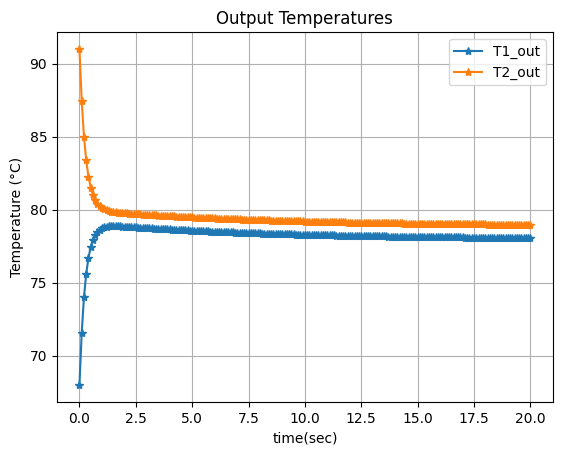

In [177]:
#PLOT THE RESULTS:
#res is a dictionary containing outputs for all instances
# the keys are integers such that res[i] stores the outputs for fmus[i]
#We are interested in output temperatures of the joint system,
T1_outs = np.array(res[n_instances-1]['T1_out'])
T2_outs = np.array(res[0]['T2_out'])

fig,ax = plt.subplots()
ax.plot(res[n_instances-1]['time'],T1_outs,'*-',label='T1_out')
ax.plot(res[0]['time'],T2_outs,'*-',label='T2_out')
ax.grid()
plt.xlabel('time(sec)')
plt.ylabel('Temperature (°C)')
plt.title('Output Temperatures')
ax.legend()